<a href="https://colab.research.google.com/github/johanesPao/ColorSkim/blob/main/ColorSkim_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ColorSkim Machine Learning

Saat ini `item_description` untuk artikel ditulis dalam bentuk/format `nama_artikel + warna` dimana pemisahan `nama_artikel` dan `warna` bervariasi antar brand, beberapa menggunakan spasi, dash, garis miring dsbnya.

Pembelajaran mesin ini merupakan pembelajaran yang akan menerapkan jaringan saraf buatan (neural network) untuk mempelajari pola penulisan artikel yang bercampur dengan warna untuk mengekstrak warna saja dari artikel.

Akan dilakukan beberapa scenario modeling **Natural Language Processing** untuk permasalahan *sequence to sequence* ini. Pada intinya kita akan membagi kalimat (`item_description`) berdasarkan kata per kata dan mengkategorikan masing - masing kata ke dalam satu dari 2 kategori warna atau bukan warna (logistik biner).

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce MX250 (UUID: GPU-ec08260a-d059-40e6-e9a6-1b23ba01dae9)


In [1]:
# Install wandb (weights and biases)
!pip install wandb

# Import modul
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb as wb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# wandb login
wb.login(key='924d78a46727fe1fb5374706bf1b8a158fe73971')

wandb: Currently logged in as: jpao (pri-data). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Membaca data

In [3]:
# Membaca data ke dalam DataFrame pandas
data = pd.read_csv('colorskim_word_dataset.csv')
data[:10]

,kata,label,urutan_kata,total_kata
0,ADISSAGE,not_color,1,2
1,BLACK/BLACK/RUNWHT,color,2,2
2,ADISSAGE,not_color,1,2
3,N.NAVY/N.NAVY/RUNWHT,color,2,2
4,3,not_color,1,6
5,STRIPE,not_color,2,6
6,D,not_color,3,6
7,29.5,not_color,4,6
8,BASKETBALL,color,5,6
9,NATURAL,color,6,6


## Eksplorasi data

In [4]:
# distribusi label dalam data
data['label'].value_counts()[:20]

not_color    439
color        148
Name: label, dtype: int64

## Konversi data ke dalam train dan test

In [5]:
from sklearn.model_selection import train_test_split
train_kata, test_kata, train_label, test_label = train_test_split(data['kata'].to_numpy(), data['label'].to_numpy(), test_size=0.3)
train_kata[:5], test_kata[:5], train_label[:5], test_label[:5]

(array(['CLIMA', 'ULTRABOOST', 'MYSINK/HIRAQU/CROYAL', 'TANGO', 'MILANO'],
       dtype=object),
 array(['SCARF', 'AC', 'MGREYH/MGREYH/BLACK', '3P', 'LINEAR'], dtype=object),
 array(['not_color', 'not_color', 'color', 'not_color', 'not_color'],
       dtype=object),
 array(['not_color', 'not_color', 'color', 'not_color', 'not_color'],
       dtype=object))

## Konversi label ke dalam numerik

In [6]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_label_encode = label_encoder.fit_transform(train_label)
test_label_encode = label_encoder.transform(test_label)
train_label_encode[:5], test_label_encode[:5]

(array([1, 1, 0, 1, 1]), array([1, 1, 0, 1, 1]))

## Model 0: model dasar

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Membuat pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit pipeline ke data training
model_0.fit(X=train_kata,
            y=train_label_encode)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [8]:
# Evaluasi model_0 pada data test
model_0.score(X=test_kata,
              y=test_label_encode)

0.9661016949152542

In [9]:
# Membuat prediksi menggunakan model_0
pred_model_0 = model_0.predict(test_kata)
pred_model_0

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0])

In [10]:
# Membuat fungsi dasar untuk menghitung accuracy, precision, recall dan f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def hitung_hasil(target, prediksi):
    """
    Menghitung accuracy, precision, recall dan f1-score dari model klasifikasi biner

    Args:
        target: label yang sebenarnya dalam bentuk 1D array
        prediksi: label yang diprediksi dalam bentuk 1D array

    Returns:
        nilai accuracy, precision, recall dan f1-score dalam bentuk dictionary
    """
    # Menghitung akurasi model
    model_akurasi = accuracy_score(target, prediksi)
    # Menghitung precision, recall dan f1-score model menggunakan "weighted average"
    model_presisi, model_recall, model_f1, _ = precision_recall_fscore_support(target, 
                                                                               prediksi, 
                                                                               average='weighted')
    
    hasil_model = {'akurasi': model_akurasi,
                   'presisi': model_presisi,
                   'recall': model_recall,
                   'f1-score': model_f1}
    
    return hasil_model

In [11]:
# Menghitung hasil model_0
model_0_hasil = hitung_hasil(target=test_label_encode,
                             prediksi=pred_model_0)
model_0_hasil

{'akurasi': 0.9661016949152542,
 'f1-score': 0.9652353913868151,
 'presisi': 0.9675649311059626,
 'recall': 0.9661016949152542}

## Menyiapkan data (text) untuk model deep sequence

### Text Vectorizer Layer

In [12]:
# jumlah data (kata) dalam train_kata
len(train_kata)

412

In [13]:
# jumlah data unik (kata unik) dalam train_kata
jumlah_kata_train = len(np.unique(train_kata))
jumlah_kata_train

226

In [14]:
# Membuat text vectorizer
from tensorflow.keras.layers import TextVectorization
vectorizer_kata = TextVectorization(max_tokens=jumlah_kata_train,
                                    output_sequence_length=1,
                                    standardize='lower')

In [15]:
# Mengadaptasikan text vectorizer ke dalam train_kata
vectorizer_kata.adapt(train_kata)

In [16]:
# Test vectorizer_kata
import random
target_kata = random.choice(train_kata)
print(f'Kata:\n{target_kata}\n')
print(f'Kata seteleah vektorisasi:\n{vectorizer_kata([target_kata])}')

Kata:
EVERLESTO

Kata seteleah vektorisasi:
[[163]]


In [17]:
vectorizer_kata.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 226,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 1,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower',
 'trainable': True,
 'vocabulary': None}

In [18]:
# Jumlah vocabulary dalam vectorizer_kata
jumlah_vocab = vectorizer_kata.get_vocabulary()
len(jumlah_vocab)

226

### Membuat Text Embedding

In [19]:
# Membuat text embedding layer
from tensorflow.keras.layers import Embedding
kata_embed = Embedding(input_dim=len(jumlah_vocab),
                       output_dim=64,
                       mask_zero=True,
                       name='layer_token_embedding')

In [20]:
# Contoh vectorizer dan embedding
print(f'Kata sebelum vektorisasi:\n{target_kata}\n')
kata_tervektor = vectorizer_kata([target_kata])
print(f'\nKata sesudah vektorisasi (sebelum embedding):\n{kata_tervektor}\n')
kata_terembed = kata_embed(kata_tervektor)
print(f'\nKata seteleh embedding:\n{kata_terembed}\n')
print(f'Shape dari kata setelah embedding: {kata_terembed.shape}')

Kata sebelum vektorisasi:
EVERLESTO


Kata sesudah vektorisasi (sebelum embedding):
[[163]]


Kata seteleh embedding:
[[[ 0.01631815 -0.04775247 -0.00520905  0.02826596 -0.02610376
   -0.02318859  0.04112567 -0.03131066 -0.0055652   0.02334623
   -0.00561842  0.00632354  0.02209767  0.02569784  0.00146017
   -0.02496719  0.04397715  0.02374946 -0.02793208 -0.02479894
   -0.02689627  0.02449668  0.02413115 -0.00026416 -0.0474188
    0.02375449 -0.03313603  0.01957679  0.01208953  0.02894038
    0.04320562  0.02123917  0.03991547  0.00471902  0.00765711
    0.02515994 -0.04454259 -0.0184782  -0.0466426   0.03179142
    0.00160015  0.03690684 -0.01465347 -0.00856692 -0.04190071
   -0.0354219   0.04571031 -0.04488987 -0.02895441  0.03390359
    0.01122769  0.00747364  0.01801378 -0.02941638 -0.03116806
   -0.04856103 -0.00071516 -0.01321958 -0.0118474   0.03304395
    0.01553127  0.00069499 -0.04673848  0.02494338]]]

Shape dari kata setelah embedding: (1, 1, 64)


# Membuat TensorFlow dataset

In [21]:
# Membuat TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_kata, train_label_encode))
test_dataset = tf.data.Dataset.from_tensor_slices((test_kata, test_label_encode))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [22]:
# Membuat TensorSliceDataset menjadi prefetced dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Model 1: Conv1D dengan embedding

In [23]:
# Membuat model_1 dengan layer Conv1D dari kata yang divektorisasi dan di-embed
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string, name='layer_input')
layer_vektor = vectorizer_kata(inputs)
layer_embed = kata_embed(layer_vektor)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(layer_embed)
x = layers.GlobalMaxPooling1D(name='layer_max_pool')(x)
outputs = layers.Dense(1, activation='sigmoid', name='layer_output')(x)
model_1 = tf.keras.Model(inputs, outputs, name='model_1_Conv1D_embed')

# Compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [24]:
# Ringkasan model_1
model_1.summary()

Model: "model_1_Conv1D_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 1)                0         
 torization)                                                     
                                                                 
 layer_token_embedding (Embe  (None, 1, 64)            14464     
 dding)                                                          
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             20544     
                                                                 
 layer_max_pool (GlobalMaxPo  (None, 64)               0         
 oling1D)                                                        
                                              

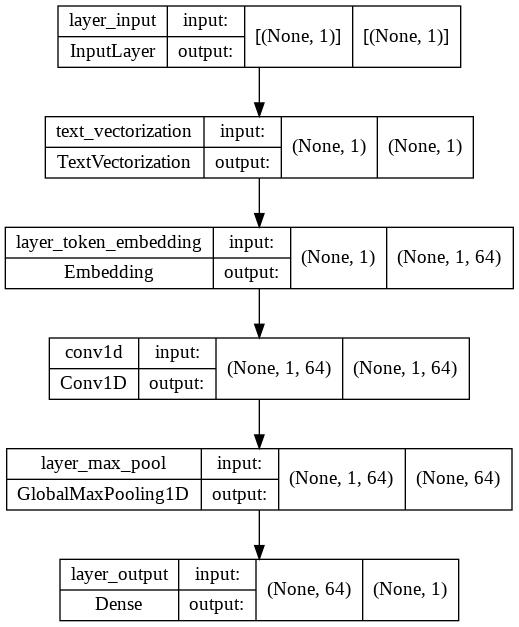

In [57]:
# Plot model_1
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes=True)

In [25]:
# import WandbCallback
from wandb.keras import WandbCallback

# Setup wandb init dan config
wb.init(project='ColorSkim',
        entity='jpao',
        name='model_1_Conv1D_embed',
        config={'epochs': 5,
                'n_layers': len(model_1.layers)})

# Fit model_1
hist_model_1 = model_1.fit(train_dataset,
                           epochs=wb.config.epochs,
                           validation_data=test_dataset,
                           callbacks=[WandbCallback()])

wandb: Currently logged in as: jpao. Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
 1/13 [=>............................] - ETA: 14s - loss: 0.6899 - accuracy: 0.7188

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220627_085711-31cyq9st/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220627_085711-31cyq9st/files/model-best)... Done. 0.1s


13/13 [==============================] - 4s 207ms/step - loss: 0.6785 - accuracy: 0.7354 - val_loss: 0.6626 - val_accuracy: 0.7514 - _timestamp: 1656320235.0000 - _runtime: 4.0000
Epoch 2/5
11/13 [========================>.....] - ETA: 0s - loss: 0.6440 - accuracy: 0.7557INFO:tensorflow:Assets written to: /content/wandb/run-20220627_085711-31cyq9st/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220627_085711-31cyq9st/files/model-best)... Done. 0.2s


13/13 [==============================] - 3s 211ms/step - loss: 0.6420 - accuracy: 0.7427 - val_loss: 0.6235 - val_accuracy: 0.7514 - _timestamp: 1656320237.0000 - _runtime: 6.0000
Epoch 3/5
 8/13 [=================>............] - ETA: 0s - loss: 0.5921 - accuracy: 0.7539INFO:tensorflow:Assets written to: /content/wandb/run-20220627_085711-31cyq9st/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220627_085711-31cyq9st/files/model-best)... Done. 0.1s


13/13 [==============================] - 3s 231ms/step - loss: 0.5802 - accuracy: 0.7427 - val_loss: 0.5659 - val_accuracy: 0.7514 - _timestamp: 1656320240.0000 - _runtime: 9.0000
Epoch 4/5
13/13 [==============================] - ETA: 0s - loss: 0.4837 - accuracy: 0.7670INFO:tensorflow:Assets written to: /content/wandb/run-20220627_085711-31cyq9st/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220627_085711-31cyq9st/files/model-best)... Done. 0.2s


13/13 [==============================] - 4s 315ms/step - loss: 0.4837 - accuracy: 0.7670 - val_loss: 0.5023 - val_accuracy: 0.7627 - _timestamp: 1656320245.0000 - _runtime: 14.0000
Epoch 5/5
 9/13 [===================>..........] - ETA: 0s - loss: 0.3733 - accuracy: 0.8333INFO:tensorflow:Assets written to: /content/wandb/run-20220627_085711-31cyq9st/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220627_085711-31cyq9st/files/model-best)... Done. 0.2s


13/13 [==============================] - 3s 276ms/step - loss: 0.3631 - accuracy: 0.8617 - val_loss: 0.4671 - val_accuracy: 0.8192 - _timestamp: 1656320250.0000 - _runtime: 19.0000


In [27]:
# Evaluasi model_1
model_1.evaluate(test_dataset)

6/6 [==============================] - 0s 5ms/step - loss: 0.4671 - accuracy: 0.8192


[0.46710270643234253, 0.8192090392112732]

In [29]:
# Membuat prediksi berdasarkan model_1
model_1_pred_prob = model_1.predict(test_dataset)
model_1_pred_prob[:10]

array([[0.79627013],
       [0.856173  ],
       [0.46073976],
       [0.8121166 ],
       [0.79627013],
       [0.8073617 ],
       [0.85300666],
       [0.90371764],
       [0.4854719 ],
       [0.79627013]], dtype=float32)

In [30]:
# Mengkonversi model_1_pred_prob dari probabilitas menjadi label
model_1_pred = tf.squeeze(tf.round(model_1_pred_prob))
model_1_pred

<tf.Tensor: shape=(177,), dtype=float32, numpy=
array([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [31]:
# Menghitung metriks model_1
model_1_hasil = hitung_hasil(target=test_label_encode,
                             prediksi=model_1_pred)
model_1_hasil

{'akurasi': 0.8192090395480226,
 'f1-score': 0.7772613766243615,
 'presisi': 0.8542715288477999,
 'recall': 0.8192090395480226}

array([[0.4478232]], dtype=float32)

## Model 2: Transfer learning pretrained feature extractor menggunakan Universal Sentence Encoder (USE)

In [34]:
# Download pretrained USE
import tensorflow_hub as hub
tf_hub_embedding = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  name='universal_sentence_encoder')

In [45]:
# Melakukan tes pretrained embedding dalam pada contoh kata
kata_acak = random.choice(train_kata)
print(f'Kata acak:\n {kata_acak}')
kata_embed_pretrain = tf_hub_embedding([kata_acak])
print(f'\nKata setelah embed dengan USE:\n{kata_embed_pretrain[0][:30]}\n')
print(f'Panjang dari kata setelah embedding: {len(kata_embed_pretrain[0])}')

Kata acak:
 CORBLU/CBLACK/FTWWHT

Kata setelah embed dengan USE:
[ 0.00860817 -0.00689607  0.05629712 -0.02064848 -0.04581999  0.0858016
  0.02770678 -0.04960595 -0.01491964  0.03378397  0.01505858  0.0569918
 -0.02326083  0.00949744 -0.06095064 -0.0286258   0.0223882   0.0515826
  0.00961048 -0.03192639  0.04371056 -0.00939714  0.01711809 -0.01394025
 -0.02168024  0.04030475 -0.01350616 -0.06460485  0.04084557  0.01243608]

Panjang dari kata setelah embedding: 512


In [49]:
# Membuat model_2 menggunakan USE
inputs = layers.Input(shape=[], dtype=tf.string, name='layer_input')
layer_embed_pretrained = tf_hub_embedding(inputs)
x = layers.Conv1D(64, kernel_size=5, activation='relu', name='layer_conv1d')(tf.expand_dims(layer_embed_pretrained, axis=-1))
x = layers.GlobalMaxPooling1D(name='layer_max_pooling')(x)
outputs = layers.Dense(1, activation='sigmoid', name='layer_output')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_Conv1D_USE_embed')

In [58]:
# Ringkasan model_2
model_2.summary()

Model: "model_2_Conv1D_USE_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_input (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 512, 1)           0         
                                                                 
 layer_conv1d (Conv1D)       (None, 508, 64)           384       
                                                                 
 layer_max_pooling (GlobalMa  (None, 64)               0         
 xPooling1D)                                                     
                                                                 
 layer_output (Dense)        (None, 1)    

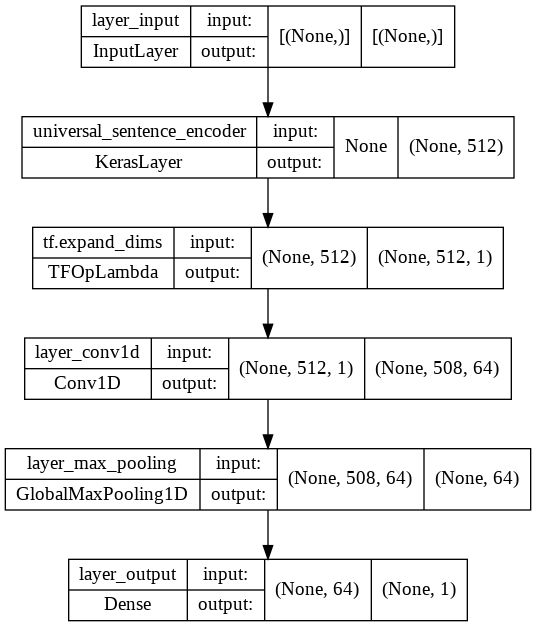

In [59]:
# Plot model_2
plot_model(model_2, show_shapes=True)

In [50]:
# Compile model_2
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [51]:
# Setup wandb init dan config
wb.init(project='ColorSkim',
        entity='jpao',
        name='model_2_Conv1D_USE_embed',
        config={'epochs': 5,
                'n_layers': len(model_2.layers)})

# Fit model_2
hist_model_2 = model_2.fit(train_dataset,
                           epochs=wb.config.epochs,
                           validation_data=test_dataset,
                           callbacks=[WandbCallback()])

accuracy,▁▁▁▃█
epoch,▁▃▅▆█
loss,█▇▆▄▁
val_accuracy,▁▁▁▂█
val_loss,█▇▅▂▁
accuracy,0.86165
best_epoch,4
best_val_loss,0.4671
epoch,4
loss,0.36305
val_accuracy,0.81921


Epoch 1/5
13/13 [==============================] - 15s 669ms/step - loss: 0.6708 - accuracy: 0.7427 - val_loss: 0.6512 - val_accuracy: 0.7514 - _timestamp: 1656322355.0000 - _runtime: 11.0000
Epoch 2/5
13/13 [==============================] - 6s 471ms/step - loss: 0.6408 - accuracy: 0.7427 - val_loss: 0.6283 - val_accuracy: 0.7514 - _timestamp: 1656322362.0000 - _runtime: 18.0000
Epoch 3/5
13/13 [==============================] - 6s 521ms/step - loss: 0.6197 - accuracy: 0.7427 - val_loss: 0.6087 - val_accuracy: 0.7514 - _timestamp: 1656322372.0000 - _runtime: 28.0000
Epoch 4/5
13/13 [==============================] - 6s 471ms/step - loss: 0.6012 - accuracy: 0.7427 - val_loss: 0.5919 - val_accuracy: 0.7514 - _timestamp: 1656322378.0000 - _runtime: 34.0000
Epoch 5/5
13/13 [==============================] - 6s 466ms/step - loss: 0.5861 - accuracy: 0.7427 - val_loss: 0.5794 - val_accuracy: 0.7514 - _timestamp: 1656322389.0000 - _runtime: 45.0000


In [52]:
# Evaluase model_2
model_2.evaluate(test_dataset)

6/6 [==============================] - 0s 19ms/step - loss: 0.5794 - accuracy: 0.7514


[0.5794160962104797, 0.7514124512672424]

In [54]:
# Membuat prediksi dengan model_2
model_2_pred_prob = model_2.predict(test_dataset)
model_2_pred_prob[:10]

array([[0.6672992 ],
       [0.67215574],
       [0.67375624],
       [0.6732286 ],
       [0.6711316 ],
       [0.67131513],
       [0.66906154],
       [0.67712283],
       [0.6757687 ],
       [0.6676929 ]], dtype=float32)

In [55]:
# Mengkonversi model_2 menjadi label format
model_2_pred = tf.squeeze(tf.round(model_2_pred_prob))
model_2_pred

<tf.Tensor: shape=(177,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [56]:
# Menghitung hasil metriks dari model_2
model_2_hasil = hitung_hasil(target=test_label_encode,
                             prediksi=model_2_pred)
model_2_hasil

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'akurasi': 0.751412429378531,
 'f1-score': 0.64476034262803,
 'presisi': 0.5646206390245458,
 'recall': 0.751412429378531}

## Model 3: Menggunakan positional kata dan custom embed dan concatenate layer

In [74]:
# Test prediksi dengan model_0 Multinomial Naive-Bayes
class_list = ['warna', 'bukan_warna']
article = 'PUMA XTG WOVEN PANTS PUMA BLACK-PUMA WHITE'
article_list = article.replace("-"," ").split()
model_test = model_0.predict(article.replace("-"," ").split())
for i in range(0, len(article_list)):
    print(f'Kata: {article_list[i]}\nPrediksi: {class_list[model_test[i]]}\n\n')

Kata: PUMA
Prediksi: bukan_warna


Kata: XTG
Prediksi: bukan_warna


Kata: WOVEN
Prediksi: bukan_warna


Kata: PANTS
Prediksi: bukan_warna


Kata: PUMA
Prediksi: bukan_warna


Kata: BLACK
Prediksi: warna


Kata: PUMA
Prediksi: bukan_warna


Kata: WHITE
Prediksi: warna


